In [1]:
import re
import nltk
import string
import pandas as pd
import re


from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.utils import resample


import pandas as pd
import re  # Regular expressions for text cleaning
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Layer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt







In [2]:
# Optional: Download stopwords if not present
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('but')
stop_words.remove('no')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the dataset
file_path = "yelp_final.csv"  # Ensure the correct path if running locally
df = pd.read_csv(file_path)
df.head()


,business_id,date,review_id,stars,text,type,user_id
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw


In [4]:
def fix_contractions(text):
    """
    Fix common English contractions with or without apostrophes.
    Converts forms like "doesnt" and "doesn't" to "does not".
    """
    contraction_map = {
        "cant": "cannot",
        "dont": "do not",
        "doesnt": "does not",
        "didnt": "did not",
        "wont": "will not",
        "shouldnt": "should not",
        "couldnt": "could not",
        "wouldnt": "would not",
        "arent": "are not",
        "isnt": "is not",
        "wasnt": "was not",
        "werent": "were not",
        "hasnt": "has not",
        "havent": "have not",
        "hadnt": "had not",
        "mustnt": "must not",
        "neednt": "need not",
        "mightnt": "might not",
        "youre": "you are",
        "theyre": "they are",
        "were": "we are",
        "im": "i am",
        "hes": "he is",
        "shes": "she is",
        "its": "it is",
        "thats": "that is",
        "theres": "there is",
        "whats": "what is",
        "whens": "when is",
        "wheres": "where is",
        "whys": "why is",
        "hows": "how is"
    }
    
    # First handle apostrophized versions by removing the apostrophe
    text = text.replace("'", "")
    
    # Then replace all contracted forms
    for contraction, expansion in contraction_map.items():
        text = text.replace(contraction, expansion)
    
    return text

df['text'] = df['text'].apply(fix_contractions)

In [5]:
print("Shape:", df.shape)

Shape: (10000, 7)


In [6]:
df.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
dtype: int64

In [7]:
print("Unique star ratings:", df['stars'].unique())

Unique star ratings: [5 4 2 3 1]


In [8]:
# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
# --------------------------
# STEP 1: TEXT CLEANING WITH LEMMATIZATION
# --------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Helper function: convert NLTK POS tag to WordNet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Clean and lemmatize function
def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"’", "'", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = text.strip()

    words = text.split()
    words = [word for word in words if word not in stop_words]  # remove stopwords
    tagged = pos_tag(words)  # POS tagging
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmatized)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [9]:
# Step 1: Remove Unnecessary Columns
df = df[['stars', 'text']]

# clean and lemmatixe
df['text'] = df['text'].apply(clean_and_lemmatize)

# Step 2: Create a Sentiment Column
df['sentiment'] = df['stars'].apply(lambda x: "negative" if x <= 2 else ("neutral" if x == 3 else "positive"))




sentiment
positive    6863
negative    1676
neutral     1461
Name: count, dtype: int64


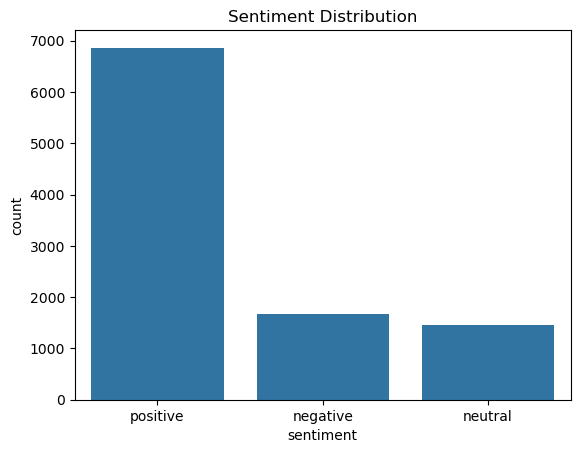

In [10]:
# Check sentiment label distribution
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()


In [11]:



positive = df[df['sentiment'] == 'positive']
neutral = df[df['sentiment'] == 'neutral']
negative = df[df['sentiment'] == 'negative']

max_count = max(len(positive), len(neutral), len(negative))

positive_upsampled = resample(positive, replace=True, n_samples=max_count, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_count, random_state=42)
negative_upsampled = resample(negative, replace=True, n_samples=max_count, random_state=42)

df_balanced = pd.concat([positive_upsampled, neutral_upsampled, negative_upsampled]).sample(frac=1).reset_index(drop=True)


sentiment
neutral     6863
negative    6863
positive    6863
Name: count, dtype: int64


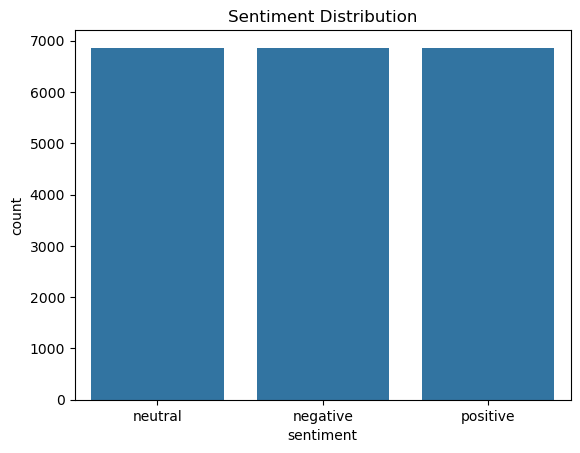

In [12]:
# Check sentiment label distribution
print(df_balanced['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df_balanced)
plt.title("Sentiment Distribution")
plt.show()


In [13]:
# Step 4 : Split the dataset


# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced['sentiment'], random_state=42)

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

# Check shape
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")



Train: 14412, Validation: 3088, Test: 3089


In [14]:
max_words_in_text = df_balanced['text'].apply(lambda x: len(x.split())).max()
print("Maximum number of words in a single review:", max_words_in_text)


Maximum number of words in a single review: 491


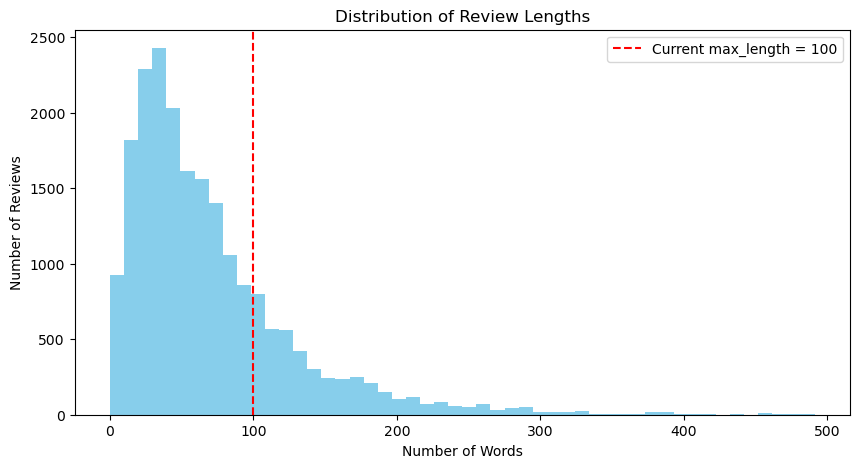

95th percentile: 185.0
99th percentile: 290.0


In [15]:
import matplotlib.pyplot as plt

review_lengths = df_balanced['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(review_lengths, bins=50, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.axvline(x=100, color='red', linestyle='--', label='Current max_length = 100')
plt.legend()
plt.show()

# Also useful:
print("95th percentile:", review_lengths.quantile(0.95))
print("99th percentile:", review_lengths.quantile(0.99))


In [16]:
all_words = " ".join(df_balanced['text']).split()
print("Unique words in dataset:", len(set(all_words)))


Unique words in dataset: 25906


In [17]:


# Step 5: Tokenization & Padding for LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
max_words = 8000
max_length = 250

# Tokenizer setup
lstm_tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(train_df['text'])

# Convert texts to padded sequences
train_sequences = pad_sequences(lstm_tokenizer.texts_to_sequences(train_df['text']), maxlen=max_length, padding='post')
val_sequences = pad_sequences(lstm_tokenizer.texts_to_sequences(val_df['text']), maxlen=max_length, padding='post')
test_sequences = pad_sequences(lstm_tokenizer.texts_to_sequences(test_df['text']), maxlen=max_length, padding='post')






In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df['sentiment'])
val_labels = label_encoder.transform(val_df['sentiment'])
test_labels = label_encoder.transform(test_df['sentiment'])

# Optional: show the mapping
print("Sentiment mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Sentiment mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Define model
lstm_model = Sequential([
    Embedding(input_dim=8000, output_dim=128, input_length=250),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),
    Dropout(0.5),
    LSTM(32, return_sequences=True),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    GlobalMaxPooling1D(),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

# Compile model
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
history = lstm_model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/5


c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


226/226 ━━━━━━━━━━━━━━━━━━━━ 198s 852ms/step - accuracy: 0.4435 - loss: 1.0241 - val_accuracy: 0.7791 - val_loss: 0.6314
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 182s 804ms/step - accuracy: 0.8681 - loss: 0.3942 - val_accuracy: 0.8925 - val_loss: 0.3751
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 195s 865ms/step - accuracy: 0.9401 - loss: 0.1964 - val_accuracy: 0.9093 - val_loss: 0.3126
Epoch 4/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 204s 904ms/step - accuracy: 0.9688 - loss: 0.1190 - val_accuracy: 0.9194 - val_loss: 0.2672
Epoch 5/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 210s 931ms/step - accuracy: 0.9763 - loss: 0.0880 - val_accuracy: 0.9310 - val_loss: 0.2377


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step

 Test Accuracy: 0.9333117513758498

 Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.97      0.95      1029
     neutral       0.91      0.95      0.93      1030
    positive       0.96      0.87      0.91      1030

    accuracy                           0.93      3089
   macro avg       0.93      0.93      0.93      3089
weighted avg       0.93      0.93      0.93      3089



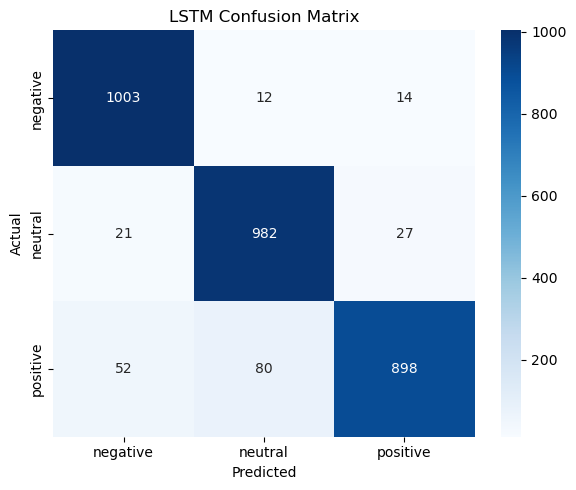

In [20]:
# Predict on test data
test_preds = np.argmax(lstm_model.predict(test_sequences), axis=1)

# Accuracy
print("\n Test Accuracy:", accuracy_score(test_labels, test_preds))

# Classification report
print("\n Classification Report:")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_, zero_division=1))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


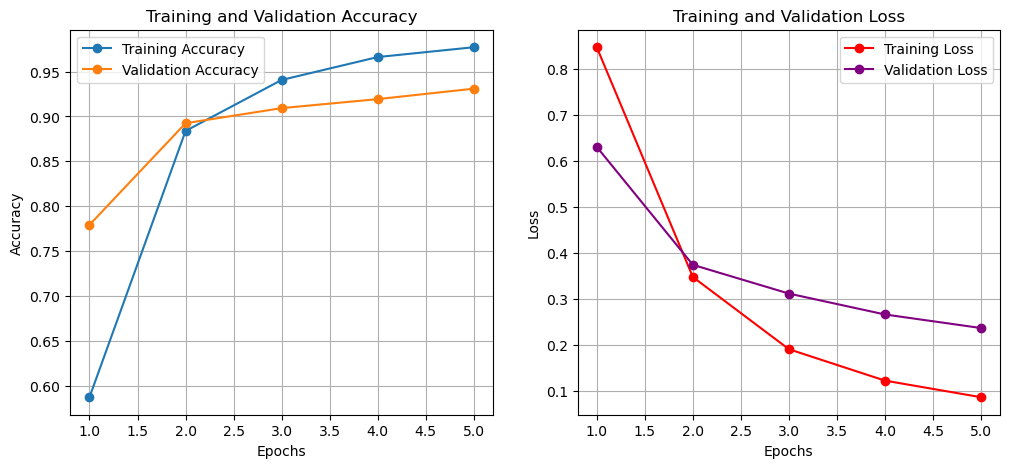

In [21]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], label='Training Loss', marker='o', color='red')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss', marker='o', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()




In [22]:
# Add text length column
test_df['length'] = test_df['text'].apply(lambda x: len(x.split()))

# Define short and long
short_reviews = test_df[test_df['length'] < 100]
long_reviews = test_df[test_df['length'] >= 100]

# Preprocess
short_seq = pad_sequences(lstm_tokenizer.texts_to_sequences(short_reviews['text']), maxlen=250, padding='post')
long_seq = pad_sequences(lstm_tokenizer.texts_to_sequences(long_reviews['text']), maxlen=250, padding='post')

# Predict
short_preds = np.argmax(lstm_model.predict(short_seq), axis=1)
long_preds = np.argmax(lstm_model.predict(long_seq), axis=1)

# Evaluate
print("Short Review Accuracy:", accuracy_score(label_encoder.transform(short_reviews['sentiment']), short_preds))
print("Long Review Accuracy:", accuracy_score(label_encoder.transform(long_reviews['sentiment']), long_preds))

from collections import Counter

def analyze_vocab(df):
    all_words = " ".join(df_balanced['text']).split()
    vocab_count = Counter(all_words)
    return len(vocab_count), sum(vocab_count.values())

short_unique, short_total = analyze_vocab(short_reviews)
long_unique, long_total = analyze_vocab(long_reviews)

print(f"Short Reviews - Unique Words: {short_unique}, Total Words: {short_total}")
print(f"Long Reviews - Unique Words: {long_unique}, Total Words: {long_total}")


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Short Review Accuracy: 0.9299336650082919
Long Review Accuracy: 0.9453471196454948
Short Reviews - Unique Words: 25906, Total Words: 1445438
Long Reviews - Unique Words: 25906, Total Words: 1445438


In [23]:
import lime.lime_text
explainer = lime.lime_text.LimeTextExplainer(class_names=label_encoder.classes_)


idx = np.random.randint(0, len(test_df))
sample_text = test_df.iloc[idx]['text']
true_label = test_df.iloc[idx]['sentiment']
print(f" Sample Text:\n{sample_text}\nTrue Label: {true_label}")

def predict_lstm(texts):
    seqs = pad_sequences(lstm_tokenizer.texts_to_sequences(texts), maxlen=250, padding='post')
    return lstm_model.predict(seqs)

lime_exp = explainer.explain_instance(sample_text, predict_lstm, num_features=10)
lime_exp.show_in_notebook()


 Sample Text:
rd star everything cannot beat price far crowd budget conscious mega store definitely cleaner side even current renovation project go dark side crowd mega store especially late hour crowd get pmam usually checker make long line hit place quieter ti ame earlier morning early evening get need without break bank
True Label: neutral
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


# Hyperparamter tuning(LSTM)

In [24]:
def build_lstm_model(dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Embedding(input_dim=8000, output_dim=128, input_length=250),
        Bidirectional(LSTM(64, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        Dropout(dropout_rate),
        LSTM(32, return_sequences=True),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(dropout_rate),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model


In [25]:
# Try different configurations
configs = [
    {"dropout_rate": 0.3, "learning_rate": 0.001, "batch_size": 32},
    {"dropout_rate": 0.5, "learning_rate": 0.0005, "batch_size": 64},
    {"dropout_rate": 0.4, "learning_rate": 0.0001, "batch_size": 32}
]

results = []

for i, config in enumerate(configs):
    print(f"\n🔧 Training Config {i+1}: {config}")
    model = build_lstm_model(config['dropout_rate'], config['learning_rate'])
    
    history = model.fit(
        train_sequences, train_labels,
        validation_data=(val_sequences, val_labels),
        epochs=5,
        batch_size=config['batch_size'],
        verbose=1
    )
    
    # Evaluate
    test_preds = np.argmax(model.predict(test_sequences), axis=1)
    acc = accuracy_score(test_labels, test_preds)
    
    results.append({
        "Config": config,
        "Test Accuracy": acc,
        "Val Accuracy Last Epoch": history.history['val_accuracy'][-1],
        "Train Accuracy Last Epoch": history.history['accuracy'][-1]
    })



🔧 Training Config 1: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/5


c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 131s 276ms/step - accuracy: 0.5199 - loss: 0.9427 - val_accuracy: 0.8310 - val_loss: 0.5122
Epoch 2/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 130s 288ms/step - accuracy: 0.9002 - loss: 0.3148 - val_accuracy: 0.8931 - val_loss: 0.3412
Epoch 3/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 137s 305ms/step - accuracy: 0.9543 - loss: 0.1548 - val_accuracy: 0.9161 - val_loss: 0.2779
Epoch 4/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 134s 297ms/step - accuracy: 0.9697 - loss: 0.1063 - val_accuracy: 0.9278 - val_loss: 0.2407
Epoch 5/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 133s 294ms/step - accuracy: 0.9785 - loss: 0.0770 - val_accuracy: 0.9258 - val_loss: 0.2494
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step

🔧 Training Config 2: {'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 64}
Epoch 1/5


c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


226/226 ━━━━━━━━━━━━━━━━━━━━ 187s 805ms/step - accuracy: 0.4297 - loss: 1.0762 - val_accuracy: 0.7199 - val_loss: 0.7591
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 200s 885ms/step - accuracy: 0.8082 - loss: 0.5109 - val_accuracy: 0.8659 - val_loss: 0.5115
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 164s 725ms/step - accuracy: 0.9134 - loss: 0.2738 - val_accuracy: 0.8967 - val_loss: 0.3961
Epoch 4/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 168s 743ms/step - accuracy: 0.9438 - loss: 0.1908 - val_accuracy: 0.9245 - val_loss: 0.3219
Epoch 5/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 167s 741ms/step - accuracy: 0.9586 - loss: 0.1419 - val_accuracy: 0.9197 - val_loss: 0.3041
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step

🔧 Training Config 3: {'dropout_rate': 0.4, 'learning_rate': 0.0001, 'batch_size': 32}
Epoch 1/5


c:\Users\karti\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 130s 277ms/step - accuracy: 0.3563 - loss: 1.1258 - val_accuracy: 0.5440 - val_loss: 1.0193
Epoch 2/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - accuracy: 0.5950 - loss: 0.8967 - val_accuracy: 0.6609 - val_loss: 0.8319
Epoch 3/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 128s 283ms/step - accuracy: 0.7133 - loss: 0.6855 - val_accuracy: 0.7639 - val_loss: 0.6829
Epoch 4/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - accuracy: 0.7991 - loss: 0.5436 - val_accuracy: 0.8067 - val_loss: 0.5986
Epoch 5/5
451/451 ━━━━━━━━━━━━━━━━━━━━ 129s 286ms/step - accuracy: 0.8510 - loss: 0.4333 - val_accuracy: 0.8403 - val_loss: 0.5350
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


In [26]:
import pandas as pd
pd.DataFrame(results)


,Config,Test Accuracy,Val Accuracy Last Epoch,Train Accuracy Last Epoch
0,"{'dropout_rate': 0.3, 'learning_rate': 0.001, ...",0.930722,0.925842,0.976755
1,"{'dropout_rate': 0.5, 'learning_rate': 0.0005,...",0.925219,0.919689,0.959339
2,"{'dropout_rate': 0.4, 'learning_rate': 0.0001,...",0.848495,0.840350,0.857202


# distilbert

In [27]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.preprocessing import LabelEncoder
from tensorflow.data import Dataset
import tensorflow as tf


In [28]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['sentiment'])
val_labels = label_encoder.transform(val_df['sentiment'])
test_labels = label_encoder.transform(test_df['sentiment'])


In [29]:
from transformers import DistilBertTokenizer

# Load tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_texts(texts, max_len=250):
    return distilbert_tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize each split
train_encodings = tokenize_texts(train_df['text'])
val_encodings = tokenize_texts(val_df['text'])
test_encodings = tokenize_texts(test_df['text'])


In [30]:
# Create TensorFlow datasets for training
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)


In [33]:
from transformers import TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer

# Custom wrapper to make DistilBERT compatible with Keras Functional API
class DistilBERTLayer(Layer):
    def __init__(self, model, **kwargs):
        super(DistilBERTLayer, self).__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cls_output = outputs[:, 0, :]  # [CLS] token
        return cls_output

base_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
input_ids = Input(shape=(250,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(250,), dtype=tf.int32, name="attention_mask")

bert_output = DistilBERTLayer(base_model)([input_ids, attention_mask])
dense = Dense(128, activation='relu')(bert_output)
dropout = Dropout(0.5)(dense)
output = Dense(3, activation='softmax')(dropout)

distilbert_model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
distilbert_model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = distilbert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1034s 1s/step - accuracy: 0.3744 - loss: 1.1388 - val_accuracy: 0.5314 - val_loss: 1.0037
Epoch 2/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1018s 1s/step - accuracy: 0.4888 - loss: 1.0116 - val_accuracy: 0.5589 - val_loss: 0.9551
Epoch 3/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1120s 1s/step - accuracy: 0.5301 - loss: 0.9631 - val_accuracy: 0.5690 - val_loss: 0.9221


194/194 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step
 Test Accuracy: 0.5781806409841372

 Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.73      0.65      1029
     neutral       0.53      0.32      0.40      1030
    positive       0.59      0.69      0.64      1030

    accuracy                           0.58      3089
   macro avg       0.57      0.58      0.56      3089
weighted avg       0.57      0.58      0.56      3089



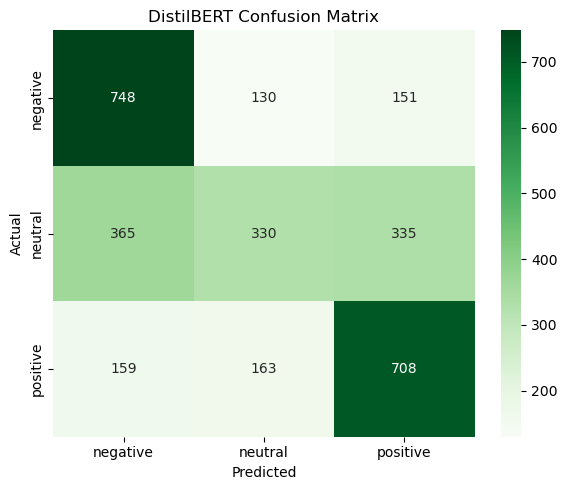

In [34]:
# Get predictions (logits) from the model
pred_logits = distilbert_model.predict(test_dataset)

# Convert logits to predicted classes
pred_labels = tf.argmax(pred_logits, axis=1).numpy()

# Classification metrics
print(" Test Accuracy:", accuracy_score(test_labels, pred_labels))

print("\n Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_, zero_division=1))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBERT Confusion Matrix")
plt.tight_layout()
plt.show()


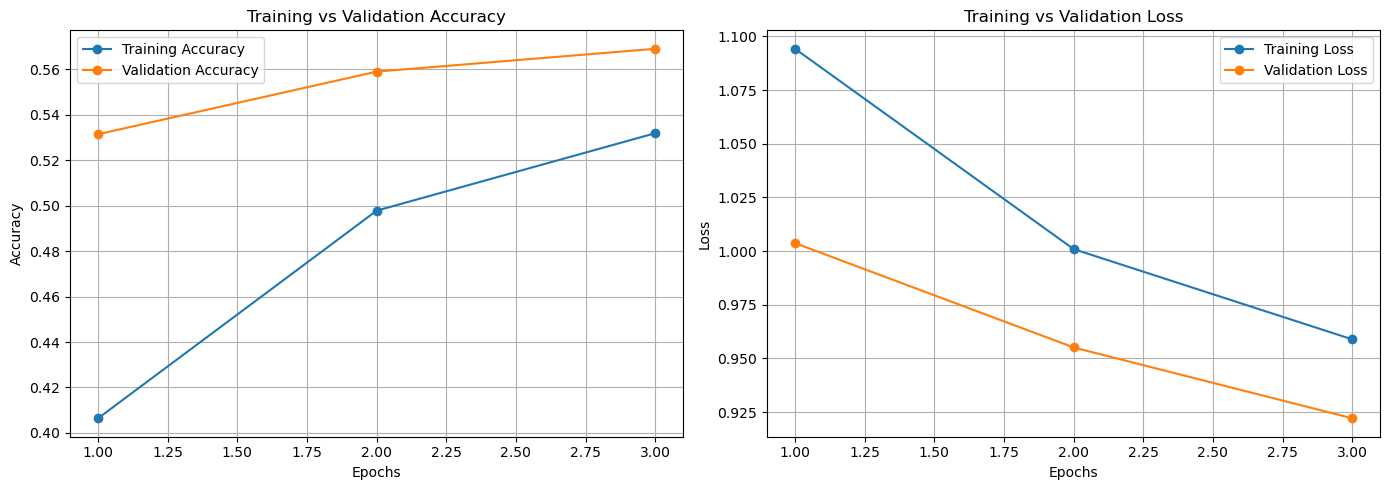

In [35]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [36]:
# Add text length
test_df['length'] = test_df['text'].apply(lambda x: len(x.split()))

# Define short and long reviews
short_reviews = test_df[test_df['length'] < 100]
long_reviews = test_df[test_df['length'] >= 100]

# Tokenize short and long sets
short_encodings = distilbert_tokenizer(
    short_reviews['text'].tolist(),
    max_length=250,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

long_encodings = distilbert_tokenizer(
    long_reviews['text'].tolist(),
    max_length=250,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Predict
short_preds = tf.argmax(distilbert_model.predict({'input_ids': short_encodings['input_ids'],
                                                  'attention_mask': short_encodings['attention_mask']}), axis=1)

long_preds = tf.argmax(distilbert_model.predict({'input_ids': long_encodings['input_ids'],
                                                 'attention_mask': long_encodings['attention_mask']}), axis=1)

# Evaluate
from sklearn.metrics import accuracy_score

print(" Short Review Accuracy:", accuracy_score(label_encoder.transform(short_reviews['sentiment']), short_preds))
print(" Long Review Accuracy:", accuracy_score(label_encoder.transform(long_reviews['sentiment']), long_preds))

from collections import Counter

# Vocabulary analysis function
def analyze_vocab(df):
    all_words = " ".join(df['text']).split()
    vocab_count = Counter(all_words)
    unique_words = len(vocab_count)
    total_words = sum(vocab_count.values())
    return unique_words, total_words

# Analyze
short_unique, short_total = analyze_vocab(short_reviews)
long_unique, long_total = analyze_vocab(long_reviews)

# Print results
print(f" Short Reviews - Unique Words: {short_unique}, Total Words: {short_total}")
print(f" Long Reviews - Unique Words: {long_unique}, Total Words: {long_total}")



76/76 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
 Short Review Accuracy: 0.5787728026533997
 Long Review Accuracy: 0.5760709010339734
 Short Reviews - Unique Words: 9554, Total Words: 108768
 Long Reviews - Unique Words: 10372, Total Words: 108228


In [37]:
import lime
import lime.lime_text
import numpy as np

# Define LIME explainer
explainer = lime.lime_text.LimeTextExplainer(class_names=label_encoder.classes_)

# Pick a random sample from the test set
idx = np.random.randint(0, len(test_df))
sample_text = test_df.iloc[idx]['text']
true_label = test_df.iloc[idx]['sentiment']
print(f" Sample Text:\n{sample_text}\nTrue Label: {true_label}")

# Define a wrapper function to return prediction probabilities for raw text
def predict_proba(texts):
    encodings = distilbert_tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors='tf')
    preds = distilbert_model.predict({'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']})
    return preds 



# Explain the instance
lime_exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
lime_exp.show_in_notebook()


 Sample Text:
yet another disappointing sushi restaurant desert date go late happy hour friday night notice hard large party get table much space table play safe ordered plate salmon nigiri notice large selection raw fish order peach soju spicy tuna tempura happy hour menu thought would get peach soju thicker substance end soju mixed peach sweetener kill alcohol maybe mistake order soju sushi joint spicy tuna tempura spicy tempura roll deep fry tempura batter sauce drizzle piece cut could taste kind kick roll stay away happy hour roll think might helpful describe roll rather list roll sheet paper choose quantity im use go sushi restaurant give free miso soup salad gyoza ise tend cheap item menu prepare give ise might keep customer come back back
True Label: negative
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step


In [38]:
from transformers import TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf

#  Wrapper for Hugging Face DistilBERT inside Keras Functional API
class DistilBERTLayer(Layer):
    def __init__(self, model, **kwargs):
        super(DistilBERTLayer, self).__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cls_output = output[:, 0, :]
        return cls_output

# Hyperparameter configs
configs = [
    {"learning_rate": 0.01, "batch_size": 16, "epochs": 3},
    {"learning_rate": 0.001, "batch_size": 16, "epochs": 3},
    {"learning_rate": 0.005, "batch_size": 32, "epochs": 4},
]

results = []

#  Run tuning loop
for i, config in enumerate(configs):
    print(f"\n🔧 Running Config {i+1}: {config}")
    
    # Load base encoder
    base_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    # Define model architecture
    input_ids = Input(shape=(250,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(250,), dtype=tf.int32, name="attention_mask")

    bert_output = DistilBERTLayer(base_model)([input_ids, attention_mask])
    dense = Dense(128, activation='relu')(bert_output)
    dropout = Dropout(0.5)(dense)
    output = Dense(3, activation='softmax')(dropout)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compile model with learning rate
    optimizer = Adam(learning_rate=config['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Prepare batched datasets
    train_ds = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).batch(config['batch_size'])

    val_ds = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(config['batch_size'])

    test_ds = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        test_labels
    )).batch(config['batch_size'])

    # Train model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config['epochs'],
        verbose=1
    )

    # Evaluate
    pred_probs = model.predict(test_ds)
    pred_labels = tf.argmax(pred_probs, axis=1).numpy()
    acc = accuracy_score(test_labels, pred_labels)

    results.append({
        "Config": config,
        "Test Accuracy": acc,
        "Val Accuracy Last Epoch": history.history['val_accuracy'][-1],
        "Train Accuracy Last Epoch": history.history['accuracy'][-1]
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)



🔧 Running Config 1: {'learning_rate': 0.01, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1318s 1s/step - accuracy: 0.4413 - loss: 1.0987 - val_accuracy: 0.5492 - val_loss: 0.9516
Epoch 2/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1155s 1s/step - accuracy: 0.4818 - loss: 1.0052 - val_accuracy: 0.5421 - val_loss: 0.9524
Epoch 3/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1142s 1s/step - accuracy: 0.4862 - loss: 0.9937 - val_accuracy: 0.5790 - val_loss: 0.9129
194/194 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step

🔧 Running Config 2: {'learning_rate': 0.001, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1175s 1s/step - accuracy: 0.4983 - loss: 0.9922 - val_accuracy: 0.5845 - val_loss: 0.8473
Epoch 2/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1149s 1s/step - accuracy: 0.5843 - loss: 0.8708 - val_accuracy: 0.5965 - val_loss: 0.8238
Epoch 3/3
901/901 ━━━━━━━━━━━━━━━━━━━━ 1147s 1s/step - accuracy: 0.5954 - loss: 0.8427 - val_accuracy: 0.6069 - val_loss: 0.8078
194/194 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step

🔧 Running Config 3: {'learning_rate': 0.005, 'batch_size': 32, 'epochs': 4}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/4
451/451 ━━━━━━━━━━━━━━━━━━━━ 1165s 3s/step - accuracy: 0.4417 - loss: 1.0586 - val_accuracy: 0.5771 - val_loss: 0.8737
Epoch 2/4
451/451 ━━━━━━━━━━━━━━━━━━━━ 1176s 3s/step - accuracy: 0.5231 - loss: 0.9346 - val_accuracy: 0.5887 - val_loss: 0.8506
Epoch 3/4
451/451 ━━━━━━━━━━━━━━━━━━━━ 1175s 3s/step - accuracy: 0.5320 - loss: 0.9229 - val_accuracy: 0.6033 - val_loss: 0.8348
Epoch 4/4
451/451 ━━━━━━━━━━━━━━━━━━━━ 1182s 3s/step - accuracy: 0.5435 - loss: 0.8989 - val_accuracy: 0.6130 - val_loss: 0.8520
97/97 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step
                                              Config  Test Accuracy  \
0  {'learning_rate': 0.01, 'batch_size': 16, 'epo...       0.570087   
1  {'learning_rate': 0.001, 'batch_size': 16, 'ep...       0.609259   
2  {'learning_rate': 0.005, 'batch_size': 32, 'ep...       0.599223   

   Val Accuracy Last Epoch  Train Accuracy Last Epoch  
0                 0.579016                   0.492021  
1                 0.606865                   0.